# Montecarlo Approximation of Electron-Matter-Interaction

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from fastai.vision.all import * 
import fastai
import torch
print("sys.version", sys.version)
print("cuda device name(0)", torch.cuda.get_device_name(0))
print("torch.__version__", torch.__version__)
print("fastai.__version__", fastai.__version__)

sys.version 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
cuda device name(0) Tesla V100S-PCIE-32GB
torch.__version__ 1.7.1
fastai.__version__ 2.7.4


In [3]:
import pathlib
input_path = Path('./data')

def get_x(input_path):
    file_names = get_image_files(input_path)
    file_names = [filename for filename in file_names if "_hf.png" in str( filename ) ]
    return file_names
    
file_names = get_x(input_path)    
print(file_names[0:5])

[Path('data/CoxSpheres_Small_01_230_hf.png'), Path('data/Fibers_01mus_01_140_hf.png'), Path('data/NonOverlappingBalls_01_255_hf.png'), Path('data/NonOverlappingBalls_01_465_hf.png'), Path('data/CoxSpheres_Large_01_20_hf.png')]


## Datensatz laden

In [4]:
def label_function(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_bse.png" )
    return str(y)

for i in range(5):
    print(file_names[i], "=>", label_function(file_names[i]))

data/CoxSpheres_Small_01_230_hf.png => data/CoxSpheres_Small_01_230_bse.png
data/Fibers_01mus_01_140_hf.png => data/Fibers_01mus_01_140_bse.png
data/NonOverlappingBalls_01_255_hf.png => data/NonOverlappingBalls_01_255_bse.png
data/NonOverlappingBalls_01_465_hf.png => data/NonOverlappingBalls_01_465_bse.png
data/CoxSpheres_Large_01_20_hf.png => data/CoxSpheres_Large_01_20_bse.png


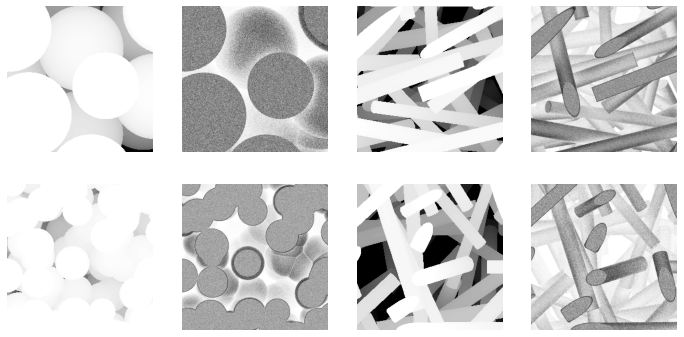

In [5]:
item_transforms  = [RandomCrop((256,256))]

datablocks = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                       get_items = get_x,
                       get_y = label_function,
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=item_transforms)

data_loader = datablocks.dataloaders(input_path, bs=4, num_workers=0 )

data_loader.show_batch( max_n=4 )

# Netzwerk Architektur

In [6]:
def conv_block( n_in, n_out ):
    return nn.Sequential ( 
        nn.Conv2d(n_in,n_out,3,padding=1), 
        nn.ReLU()
    )

class ResNetBlock(nn.Module):
    def __init__(self, 
                 n_features: int,
                 activation: torch.nn.Module = nn.ReLU(inplace=True) ):
        super().__init__()
        self.conv_1 = nn.Conv2d( n_features, n_features, 3, padding=1 ).cuda()
        self.conv_2 = nn.Conv2d( n_features, n_features, 3, padding=1 ).cuda()
        self.activation = activation

    def conv_path( self, x ):
        x = self.conv_1( x )
        x = self.activation( x )
        x = self.conv_2( x )
        x = self.activation( x )
        # print("ConvPath return x",x.shape)
        return x
        
    def forward(self, x):
        # print("ResnetBlock x",x.shape)
        return x + self.conv_path( x )
    
class EncoderBlock(nn.Module):
    def __init__(self, 
                 n_features: int ):
        super().__init__()
        self.conv = ResNetBlock( n_features )
        self.pool = nn.MaxPool2d( 2 )
        
    def forward(self, x):
        # print("EncoderBlock")
        highres = self.conv( x )
        return self.pool( highres ), highres
    
class MonteCarloUnet(nn.Module):
    def __init__(self, 
                 n_blocks: int,
                 n_features: int ):
        super().__init__()
        self.n_blocks = n_blocks
        self.start = nn.Conv2d( 1, n_features, 3, padding=1 )
        self.encoder    = [ EncoderBlock(n_features) for i in range(n_blocks)]
        self.decoder    = [ ResNetBlock( n_features ) for i in range(n_blocks)]
        self.transition = [ nn.Conv2d( 2*n_features, n_features, 3, padding=1 ).cuda() for i in range(n_blocks)]
        self.finish = conv_block(n_features,1)
        
    def forward(self, x):
        skip = []
        # print("x", x.shape)
        # print("self.start(x)" )
        x = self.start(x)
        # print("x", x.shape )
        for i in range(len(self.encoder)):
            # print("======================")
            # print("=====self.encoder[", i, "]")
            x, highres = self.encoder[i]( x )
            # print("x", x.shape, highres.shape )
            skip.append( highres ) 
        for i in range(len(self.encoder)):
            # print("======================")
            # print("=====self.decoder[", i, "]")
            # print("x", x.shape)
            # print("upsample", x.shape)
            x = torch.nn.functional.upsample( x, scale_factor=2 ) 
            # print("cat", x.shape, skip[len(skip)-i-1].shape)
            x = torch.cat( ( x, skip[len(skip)-i-1] ), 1 )
            # print("transitioning x", x.shape)
            x = self.transition[self.n_blocks-i-1]( x )
            # print("decoding x", x.shape)
            x = self.decoder[self.n_blocks-i-1]( x )
            # print("x", x.shape)
        return self.finish(x)

## Determine Learning Rate

In [7]:
# learner.save("custom_initial")
# learner.lr_find()

In [14]:
learning_rate=0.001

## Training 

MonteCarloUnet
n_blocks 7 n_features 128


epoch,train_loss,valid_loss,time
0,0.352394,0.312440,00:12
1,0.213073,0.109539,00:12
2,0.134229,0.099598,00:12
3,0.112115,0.098761,00:12
4,0.105343,0.097717,00:12
5,0.103813,0.096811,00:12
6,0.101977,0.096548,00:12
7,0.100558,0.094402,00:12
8,0.099221,0.094345,00:12
9,0.098504,0.106718,00:12


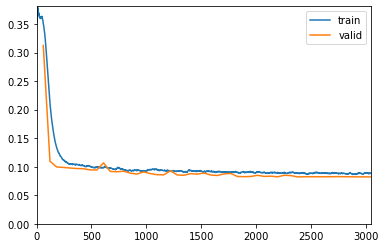

[0.08851480484008789, 0.08220731467008591]


In [15]:
fname = "MonteCarloUnet"
print(fname)
for n_blocks in [7]:
    for n_features in [128]:
        print("n_blocks", n_blocks, "n_features", n_features)
        model = MonteCarloUnet( n_blocks, n_features )
        learner = Learner( data_loader, model, loss_func=L1LossFlat() )
        learner.fit_one_cycle( 50, lr_max=learning_rate, cbs=[ShowGraphCallback()] )
        print( learner.recorder.final_record )

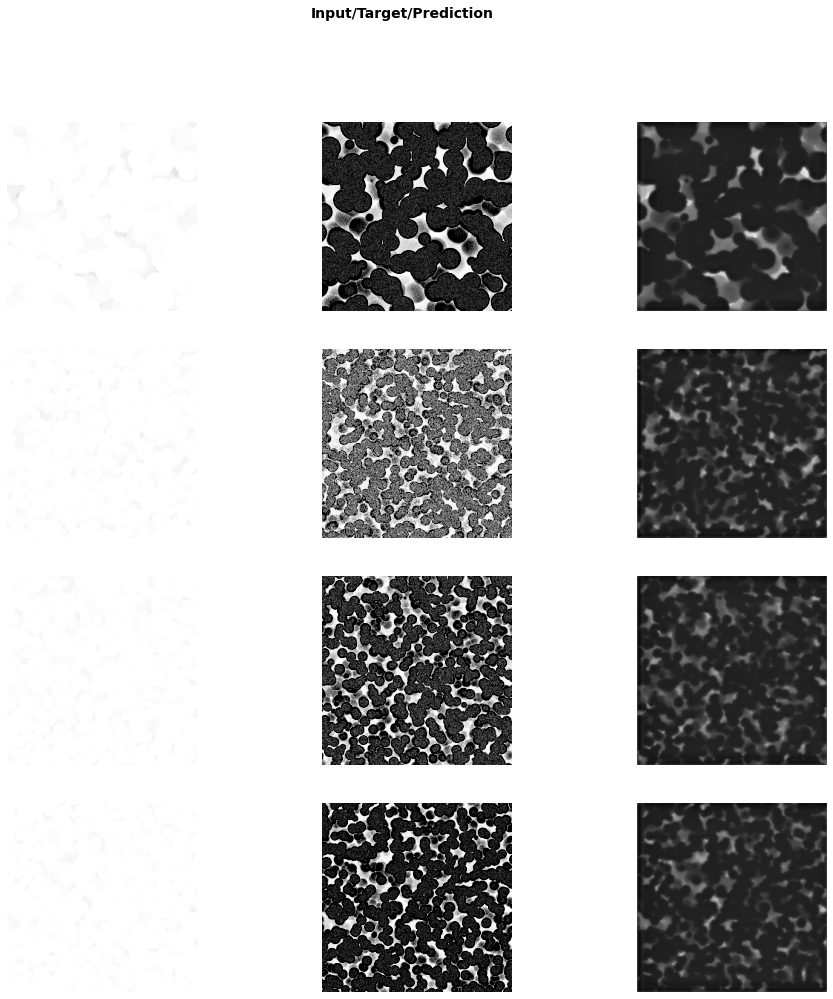

In [16]:
learner.show_results( figsize=(16,16), vmin=0, vmax=128 )

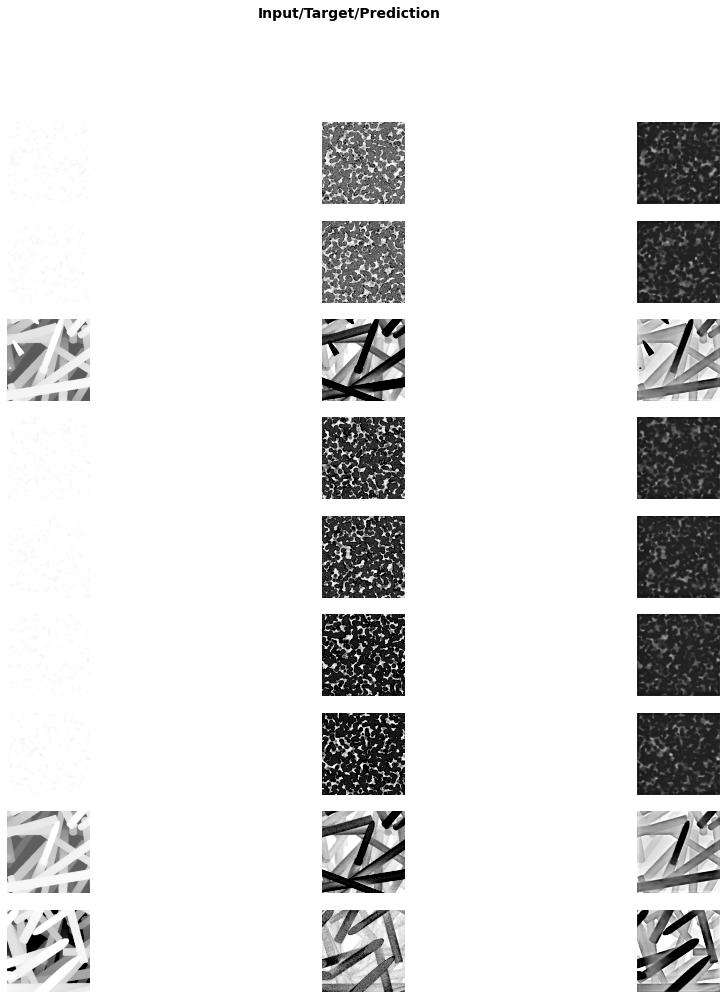

In [17]:
from torchvision.utils import save_image

interpretation = Interpretation.from_learner( learner )
values,indices = interpretation.top_losses(k=9)
for i,idx in enumerate(indices):
    inps, preds, targs, decoded, loss = interpretation[idx]
    save_image(inps, "input_" + str(i) + ".png")
    save_image(preds, "prediction_" + str(i) + ".png")
    save_image(targs, "target_" + str(i) + ".png")
    save_image(decoded, "decoded_" + str(i) + ".png")
interpretation.show_results( indices, figsize=(16,16), vmin=0, vmax=128 )